# Food Recommendation System

In [37]:
import sklearn
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
from gensim.models import KeyedVectors
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [38]:
temp = pd.read_csv('../input/foodcom-recipes-and-reviews/recipes.csv')
temp = temp[['Name', 'Description']]
temp['Name'] = temp['Name'].str.lower()
temp.head()

,Name,Description
0,low-fat berry blue frozen dessert,Make and share this Low-Fat Berry Blue Frozen ...
1,biryani,Make and share this Biryani recipe from Food.com.
2,best lemonade,This is from one of my first Good House Keepi...
3,carina's tofu-vegetable kebabs,This dish is best prepared a day in advance to...
4,cabbage soup,Make and share this Cabbage Soup recipe from F...


In [3]:
df = pd.read_csv('../input/ir-project/food_sample.csv')
df = df.merge(temp, how='left', on='Name')
df.head()

,Name,Category,Veg/Non-Veg,Nutrient,Disease,Diet,Ingredients,Description
0,summer squash salad,salad,veg,fiber,obesity diabeties hypertension goitre,alkaline_diet low_fat_diet ketogenic_diet low_...,"white balsamic vinegar, lemon juice, lemon rin...","Fast, easy, light, and good! I love this durin..."
1,summer squash salad,salad,veg,fiber,obesity diabeties hypertension goitre,alkaline_diet low_fat_diet ketogenic_diet low_...,"white balsamic vinegar, lemon juice, lemon rin...",Make and share this Summer Squash Salad recipe...
2,chicken minced salad,salad,non-veg,fiber,anemia pregnancy hypertension rickets goitre k...,low_fat_diet low_carb_diet ketogenic_diet low_...,"olive oil, chicken mince, garlic (minced), oni...",NaN
3,sweet chilli almonds,chilli,veg,vitamin_a,hypertension scurvy heart_disease goitre kidne...,alkaline_diet low_fat_diet paleo_diet Mediterr...,"almonds whole, egg white, curry leaves, salt, ...",NaN
4,tricolour salad,salad,veg,fiber,obesity goitre hypertension,low_fat_diet ketogenic_diet low_sodium_diet hi...,"vinegar, honey/sugar, soy sauce, salt, garlic ...",NaN


In [4]:
df['text'] = df['Name'].astype(str)+' '+df['Category'].astype(str)+' '+df['Veg/Non-Veg'].astype(str)+' '+df['Nutrient'].astype(str)+' '+df['Disease'].astype(str)+' '+df['Diet'].astype(str)+' '+df['Ingredients'].astype(str)+' '+df['Description'].astype(str)
df.head()

,Name,Category,Veg/Non-Veg,Nutrient,Disease,Diet,Ingredients,Description,text
0,summer squash salad,salad,veg,fiber,obesity diabeties hypertension goitre,alkaline_diet low_fat_diet ketogenic_diet low_...,"white balsamic vinegar, lemon juice, lemon rin...","Fast, easy, light, and good! I love this durin...",summer squash salad salad veg fiber obesity di...
1,summer squash salad,salad,veg,fiber,obesity diabeties hypertension goitre,alkaline_diet low_fat_diet ketogenic_diet low_...,"white balsamic vinegar, lemon juice, lemon rin...",Make and share this Summer Squash Salad recipe...,summer squash salad salad veg fiber obesity di...
2,chicken minced salad,salad,non-veg,fiber,anemia pregnancy hypertension rickets goitre k...,low_fat_diet low_carb_diet ketogenic_diet low_...,"olive oil, chicken mince, garlic (minced), oni...",NaN,chicken minced salad salad non-veg fiber anemi...
3,sweet chilli almonds,chilli,veg,vitamin_a,hypertension scurvy heart_disease goitre kidne...,alkaline_diet low_fat_diet paleo_diet Mediterr...,"almonds whole, egg white, curry leaves, salt, ...",NaN,sweet chilli almonds chilli veg vitamin_a hype...
4,tricolour salad,salad,veg,fiber,obesity goitre hypertension,low_fat_diet ketogenic_diet low_sodium_diet hi...,"vinegar, honey/sugar, soy sauce, salt, garlic ...",NaN,tricolour salad salad veg fiber obesity goitre...


## Preprocessing:

In [5]:
def convert_lower_case(data):
    return np.char.lower(data)

def remove_punctuation(data):
    symbols = """!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r"""
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

def remove_stop_words(data):
    words = word_tokenize(str(data))
    res = ' '.join([word for word in words if word not in cachedStopWords])
    return np.char.strip(res)

def tf(word, counter):
    return counter[word] / len(counter)

def tf_binary(word, counter):
    if counter[word]>0:
        return 1
    return 0

def tf_rawcount(word, counter):
    return counter[word]

def tf_lognorm(word, counter):
    return math.log(1+counter[word])

def idf(word, postings):
    return math.log(len(postings) / (1 + postings[word]))

def lemmatization(data):
    lemmatizer = WordNetLemmatizer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + lemmatizer.lemmatize(w)
    return np.char.strip(new_text)

def preprocess(data):
    data = convert_lower_case(data)
    data = remove_punctuation(data)
    data = remove_stop_words(data)
    data = lemmatization(data)
    return data

In [6]:
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
import re
import numpy as np
from tqdm import tqdm
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

cachedStopWords = stopwords.words("english")

In [8]:
def clean_text(data_df):
    for index, row in tqdm(data_df.iterrows()):
        sample = row['text']
        data_df.loc[index, 'text'] = str(preprocess(sample))
    return data_df

df = clean_text(df.copy())
df.head()

860it [00:03, 249.72it/s]


,Name,Category,Veg/Non-Veg,Nutrient,Disease,Diet,Ingredients,Description,text
0,summer squash salad,salad,veg,fiber,obesity diabeties hypertension goitre,alkaline_diet low_fat_diet ketogenic_diet low_...,"white balsamic vinegar, lemon juice, lemon rin...","Fast, easy, light, and good! I love this durin...",summer squash salad salad veg fiber obesity di...
1,summer squash salad,salad,veg,fiber,obesity diabeties hypertension goitre,alkaline_diet low_fat_diet ketogenic_diet low_...,"white balsamic vinegar, lemon juice, lemon rin...",Make and share this Summer Squash Salad recipe...,summer squash salad salad veg fiber obesity di...
2,chicken minced salad,salad,non-veg,fiber,anemia pregnancy hypertension rickets goitre k...,low_fat_diet low_carb_diet ketogenic_diet low_...,"olive oil, chicken mince, garlic (minced), oni...",NaN,chicken minced salad salad non veg fiber anemi...
3,sweet chilli almonds,chilli,veg,vitamin_a,hypertension scurvy heart_disease goitre kidne...,alkaline_diet low_fat_diet paleo_diet Mediterr...,"almonds whole, egg white, curry leaves, salt, ...",NaN,sweet chilli almond chilli veg vitamin hyperte...
4,tricolour salad,salad,veg,fiber,obesity goitre hypertension,low_fat_diet ketogenic_diet low_sodium_diet hi...,"vinegar, honey/sugar, soy sauce, salt, garlic ...",NaN,tricolour salad salad veg fiber obesity goitre...


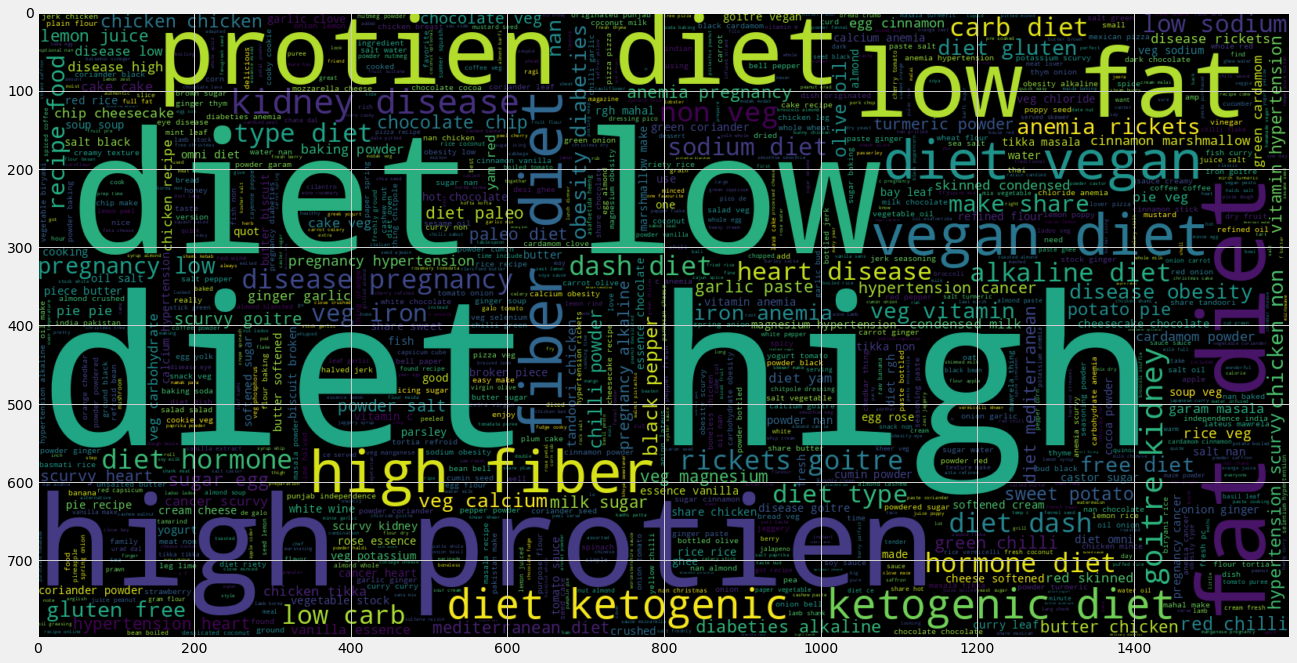

In [9]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df.text))
plt.imshow(wc , interpolation = 'bilinear')
plt.savefig('wordcloud.png')

## PipeLine Stage 1:

### Actual Values

In [10]:
df.loc[df['text'].str.contains('chinese')]

,Name,Category,Veg/Non-Veg,Nutrient,Disease,Diet,Ingredients,Description,text
70,fish with jamun sauce,snacks,non-veg,vitamin_a,anemia pregnancy hypertension cancer heart_dis...,alkaline_diet low_fat_diet ketogenic_diet vega...,"Jamun, Chinese, Chilli, Garlic buds, cumin pow...",NaN,fish jamun sauce snack non veg vitamin anemia ...
133,spiced coffee,coffee,veg,manganese,pregnancy anemia,low_fat_diet ketogenic_diet vegan_diet high_fi...,"Fresh PC Coffee, Coffee Powder, Ginger, Milk, ...",A deliciously spiced coffee which enhances the...,spiced coffee coffee veg manganese pregnancy a...
134,spiced coffee,coffee,veg,manganese,pregnancy anemia,low_fat_diet ketogenic_diet vegan_diet high_fi...,"Fresh PC Coffee, Coffee Powder, Ginger, Milk, ...",Make and share this Spiced Coffee recipe from ...,spiced coffee coffee veg manganese pregnancy a...
135,spiced coffee,coffee,veg,manganese,pregnancy anemia,low_fat_diet ketogenic_diet vegan_diet high_fi...,"Fresh PC Coffee, Coffee Powder, Ginger, Milk, ...",Make and share this Spiced Coffee recipe from ...,spiced coffee coffee veg manganese pregnancy a...
136,spiced coffee,coffee,veg,manganese,pregnancy anemia,low_fat_diet ketogenic_diet vegan_diet high_fi...,"Fresh PC Coffee, Coffee Powder, Ginger, Milk, ...",Make and share this Spiced Coffee recipe from ...,spiced coffee coffee veg manganese pregnancy a...
137,spiced coffee,coffee,veg,manganese,pregnancy anemia,low_fat_diet ketogenic_diet vegan_diet high_fi...,"Fresh PC Coffee, Coffee Powder, Ginger, Milk, ...",Make and share this Spiced Coffee recipe from ...,spiced coffee coffee veg manganese pregnancy a...
170,garlic soya chicken,chicken,non-veg,iron,anemia hypertension cancer heart_disease ricke...,alkaline_diet low_fat_diet low_carb_diet vegan...,chicken thigh/breast (cut crosswise into 1/2-i...,NaN,garlic soya chicken chicken non veg iron anemi...
181,chicken fritters,chicken,non-veg,iron,anemia rickets goitre kidney_disease pregnancy,low_fat_diet low_carb_diet vegan_diet high_fib...,Chicken (chopped in boneless and small pieces)...,I got this recipe from the Asian guy that work...,chicken fritter chicken non veg iron anemia ri...
185,chicken in mahalak sauce,chicken,non-veg,iron,anemia rickets goitre kidney_disease pregnancy,low_fat_diet low_carb_diet vegan_diet high_fib...,"Salt, Chinese, Seasoning, Oil, Corn Fallore, C...",NaN,chicken mahalak sauce chicken non veg iron ane...
235,fish with jamun sauce,sauce,non-veg,vitamin_a,anemia pregnancy hypertension cancer heart_dis...,alkaline_diet low_fat_diet ketogenic_diet vega...,"Jamun, Chinese, Chilli, Garlic buds, cumin pow...",NaN,fish jamun sauce sauce non veg vitamin anemia ...


### BERT Embeddings:

In [11]:
!pip -q install sentence_transformers

In [12]:
from sentence_transformers import SentenceTransformer

In [13]:
bert = SentenceTransformer('bert-base-nli-mean-tokens')
bert_embeddings = bert.encode(df['text']).tolist()

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

In [14]:
def filter_bert(data, embeddings, input_, n=100):
    df = data.copy()
    
    input_ = str(preprocess(input_))
    processed_input = bert.encode([input_]).tolist()

    df['Scores'] = cosine_similarity(processed_input, embeddings).reshape(-1)

    filtered_df = df.sort_values('Scores', ascending=False).head(n).reset_index(drop=True)
    return filtered_df

yo = filter_bert(df, bert_embeddings, 'chinese')
yo.head()

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,Name,Category,Veg/Non-Veg,Nutrient,Disease,Diet,Ingredients,Description,text,Scores
0,sunga pork,curry,veg,iron,pregnancy goitre,low_fat_diet paleo_diet vegan_diet high_fiber_...,curry,NaN,sunga pork curry veg iron pregnancy goitre low...,0.209410
1,grilled lemon margarita,margarita,veg,vitamin_c,scurvy goitre,vegan_diet,"vanilla infused tequila, vanilla liqueur, lemo...",NaN,grilled lemon margarita margarita veg vitamin ...,0.168083
2,mushroom matar,matar,veg,iron,kidney_disease,vegan_diet low_fat_diet high_fiber_diet,eet peas in a masala/chili sauce,NaN,mushroom matar matar veg iron kidney disease v...,0.147621
3,banana chips,banana,veg,magnesium,hypertension,alkaline_diet high_protien_diet vegan_diet hig...,r dried slices of bananas (fruits of herbaceou...,Make and share this Banana Chips recipe from F...,banana chip banana veg magnesium hypertension ...,0.144625
4,flattened rice / pohe,rice,veg,carbohydrates,anemia cancer scurvy heart_disease eye_disease...,alkaline_diet low_fat_diet ketogenic_diet vega...,"ible, dehusked rice which is flattened into fl...",NaN,flattened rice pohe rice veg carbohydrate anem...,0.143626


### Tf-Idf Vectorizer

In [15]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_embeddings = tfidf_vectorizer.fit_transform(df['text'])
tfidf_embeddings = tfidf_embeddings.toarray()

In [16]:
def filter_tfidf(data, embeddings, input_, n=100):
    df = data.copy()
    
    input_ = str(preprocess(input_))
    processed_input = tfidf_vectorizer.transform([input_])
    
    df['Scores'] = cosine_similarity(processed_input, embeddings).reshape(-1)

    filtered_df = df.sort_values('Scores', ascending=False).head(n).reset_index(drop=True)
    return filtered_df

yo = filter_tfidf(df, tfidf_embeddings, 'chinese')
yo.head()

,Name,Category,Veg/Non-Veg,Nutrient,Disease,Diet,Ingredients,Description,text,Scores
0,red rice vermicelli kheer,kheer,veg,carbohydrates,anemia pregnancy cancer scurvy kidney_disease ...,alkaline_diet ketogenic_diet vegan_diet high_p...,Red Rice Vermiseli / Broken Suzy / Suzy Vermis...,NaN,red rice vermicelli kheer kheer veg carbohydra...,0.329538
1,red rice vermicelli kheer,kheer,veg,carbohydrates,anemia pregnancy cancer scurvy kidney_disease ...,alkaline_diet ketogenic_diet vegan_diet high_p...,Red Rice Vermiseli / Broken Suzy / Suzy Vermis...,NaN,red rice vermicelli kheer kheer veg carbohydra...,0.329538
2,chocolate doughnut,chocolate,veg,magnesium,hypertension heart_disease,high_protien_diet high_fiber_diet ketogenic_diet,"Chinese, yellow part, egg, butter, yeast, milk",NaN,chocolate doughnut chocolate veg magnesium hyp...,0.315144
3,camel milk cake tart,cake,veg,vitamin_d,cancer hypertension kidney_disease rickets,low_fat_diet ketogenic_diet high_fiber_diet hi...,"Camel Milk, Chinese, Vinegar, Butter, Brown Su...",NaN,camel milk cake tart cake veg vitamin cancer h...,0.231484
4,fish with jamun sauce,snacks,non-veg,vitamin_a,anemia pregnancy hypertension cancer heart_dis...,alkaline_diet low_fat_diet ketogenic_diet vega...,"Jamun, Chinese, Chilli, Garlic buds, cumin pow...",NaN,fish jamun sauce snack non veg vitamin anemia ...,0.212709


### Count Vectorizer

In [17]:
count_vectorizer = CountVectorizer()
count_embeddings = count_vectorizer.fit_transform(df['text'])
count_embeddings = count_embeddings.toarray()

In [18]:
def filter_count(data, embeddings, input_, n=100):
    df = data.copy()
    
    input_ = str(preprocess(input_))
    processed_input = count_vectorizer.transform([input_])
    
    df['Scores'] = cosine_similarity(processed_input, embeddings).reshape(-1)

    filtered_df = df.sort_values('Scores', ascending=False).head(n).reset_index(drop=True)
    return filtered_df

yo = filter_count(df, count_embeddings, 'chinese')
yo.head()

,Name,Category,Veg/Non-Veg,Nutrient,Disease,Diet,Ingredients,Description,text,Scores
0,red rice vermicelli kheer,kheer,veg,carbohydrates,anemia pregnancy cancer scurvy kidney_disease ...,alkaline_diet ketogenic_diet vegan_diet high_p...,Red Rice Vermiseli / Broken Suzy / Suzy Vermis...,NaN,red rice vermicelli kheer kheer veg carbohydra...,0.229416
1,red rice vermicelli kheer,kheer,veg,carbohydrates,anemia pregnancy cancer scurvy kidney_disease ...,alkaline_diet ketogenic_diet vegan_diet high_p...,Red Rice Vermiseli / Broken Suzy / Suzy Vermis...,NaN,red rice vermicelli kheer kheer veg carbohydra...,0.229416
2,chocolate doughnut,chocolate,veg,magnesium,hypertension heart_disease,high_protien_diet high_fiber_diet ketogenic_diet,"Chinese, yellow part, egg, butter, yeast, milk",NaN,chocolate doughnut chocolate veg magnesium hyp...,0.171499
3,camel milk cake tart,cake,veg,vitamin_d,cancer hypertension kidney_disease rickets,low_fat_diet ketogenic_diet high_fiber_diet hi...,"Camel Milk, Chinese, Vinegar, Butter, Brown Su...",NaN,camel milk cake tart cake veg vitamin cancer h...,0.125988
4,spiced coffee,coffee,veg,manganese,pregnancy anemia,low_fat_diet ketogenic_diet vegan_diet high_fi...,"Fresh PC Coffee, Coffee Powder, Ginger, Milk, ...",Make and share this Spiced Coffee recipe from ...,spiced coffee coffee veg manganese pregnancy a...,0.113228


### FastText Embeddings

In [19]:
FILE_PATH = '../input/fasttext-wikinews/wiki-news-300d-1M.vec'
keyed_vec = KeyedVectors.load_word2vec_format(FILE_PATH)

In [20]:
def mean_fasttext(arr, embedding_dim=300):
    mean_vectors = []
    for document in tqdm(arr):
        tokens = nltk.tokenize.word_tokenize(document)
        vectors = [keyed_vec.get_vector(token) for token in tokens if token in keyed_vec.key_to_index.keys()]
        if vectors:
            mean_vec = np.vstack(vectors).mean(axis=0)
            mean_vectors.append(mean_vec)
        else:
            mean_vectors.append(np.zeros(embedding_dim))
    embedding = np.vstack(mean_vectors)
    return embedding

fasttext_embeddings = mean_fasttext(df['text'])

100%|██████████| 860/860 [00:00<00:00, 1999.06it/s]


In [21]:
def filter_fasttext(data, embeddings, input_, n=100):
    df = data.copy()
    
    input_ = str(preprocess(input_))
    processed_input = mean_fasttext([input_])
    
    df['Scores'] = cosine_similarity(processed_input, embeddings).reshape(-1)

    filtered_df = df.sort_values('Scores', ascending=False).head(n).reset_index(drop=True)
    return filtered_df

yo = filter_fasttext(df, fasttext_embeddings, 'chinese')
yo.head()

100%|██████████| 1/1 [00:00<00:00, 1718.27it/s]


,Name,Category,Veg/Non-Veg,Nutrient,Disease,Diet,Ingredients,Description,text,Scores
0,buldak (hot and spicy chicken),chicken,non-veg,magnesium,obesity,high_protien_diet high_fiber_diet,"chicken drum sticks/ chicken breast, soy sauce...",NaN,buldak hot spicy chicken chicken non veg magne...,0.571478
1,puffed rice,rice,veg,carbohydrates,obesity diabeties anemia,high_protien_diet vegan_diet dash_diet ketogen...,grain made from rice; usually made by heating ...,NaN,puffed rice rice veg carbohydrate obesity diab...,0.569338
2,red rice vermicelli kheer,kheer,veg,carbohydrates,anemia pregnancy cancer scurvy kidney_disease ...,alkaline_diet ketogenic_diet vegan_diet high_p...,Red Rice Vermiseli / Broken Suzy / Suzy Vermis...,NaN,red rice vermicelli kheer kheer veg carbohydra...,0.565046
3,red rice vermicelli kheer,kheer,veg,carbohydrates,anemia pregnancy cancer scurvy kidney_disease ...,alkaline_diet ketogenic_diet vegan_diet high_p...,Red Rice Vermiseli / Broken Suzy / Suzy Vermis...,NaN,red rice vermicelli kheer kheer veg carbohydra...,0.565046
4,japanese curry arancini with barley salsa,snacks,veg,calcium,goitre,high_protien_diet vegan_diet low_fat_diet keto...,"japanese curry, sticky rice, cheese inside ric...",NaN,japanese curry arancini barley salsa snack veg...,0.559631


# SOTA Pipeline (Stage 1):

In [22]:
def filter_SOTA(data, embeddings1, embeddings2, embeddings3, embeddings4, input_, n=100):
    df = data.copy()
    
    input_ = str(preprocess(input_))
    
    processed_input = bert.encode([input_]).tolist()
    df['bert_score'] = cosine_similarity(processed_input, embeddings1).reshape(-1)
    
    processed_input = tfidf_vectorizer.transform([input_])
    df['tfidf_score'] = cosine_similarity(processed_input, embeddings2).reshape(-1)
    
    processed_input = count_vectorizer.transform([input_])
    df['count_score'] = cosine_similarity(processed_input, embeddings3).reshape(-1)
    
    processed_input = mean_fasttext([input_])
    df['fasttext_score'] = cosine_similarity(processed_input, embeddings4).reshape(-1)
    
    df['ensemble_score'] = 0.8*df['count_score'] + 0.2*df['tfidf_score']
    
    filtered_df = df.sort_values('ensemble_score', ascending=False).head(n).reset_index(drop=True)
    return filtered_df

yo = filter_SOTA(df, bert_embeddings, tfidf_embeddings, count_embeddings, fasttext_embeddings, 'chinese')
yo.head()

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1006.07it/s]


,Name,Category,Veg/Non-Veg,Nutrient,Disease,Diet,Ingredients,Description,text,bert_score,tfidf_score,count_score,fasttext_score,ensemble_score
0,red rice vermicelli kheer,kheer,veg,carbohydrates,anemia pregnancy cancer scurvy kidney_disease ...,alkaline_diet ketogenic_diet vegan_diet high_p...,Red Rice Vermiseli / Broken Suzy / Suzy Vermis...,NaN,red rice vermicelli kheer kheer veg carbohydra...,0.129640,0.329538,0.229416,0.565046,0.249440
1,red rice vermicelli kheer,kheer,veg,carbohydrates,anemia pregnancy cancer scurvy kidney_disease ...,alkaline_diet ketogenic_diet vegan_diet high_p...,Red Rice Vermiseli / Broken Suzy / Suzy Vermis...,NaN,red rice vermicelli kheer kheer veg carbohydra...,0.129640,0.329538,0.229416,0.565046,0.249440
2,chocolate doughnut,chocolate,veg,magnesium,hypertension heart_disease,high_protien_diet high_fiber_diet ketogenic_diet,"Chinese, yellow part, egg, butter, yeast, milk",NaN,chocolate doughnut chocolate veg magnesium hyp...,0.093720,0.315144,0.171499,0.526493,0.200228
3,camel milk cake tart,cake,veg,vitamin_d,cancer hypertension kidney_disease rickets,low_fat_diet ketogenic_diet high_fiber_diet hi...,"Camel Milk, Chinese, Vinegar, Butter, Brown Su...",NaN,camel milk cake tart cake veg vitamin cancer h...,0.052911,0.231484,0.125988,0.504157,0.147087
4,spiced coffee,coffee,veg,manganese,pregnancy anemia,low_fat_diet ketogenic_diet vegan_diet high_fi...,"Fresh PC Coffee, Coffee Powder, Ginger, Milk, ...",Make and share this Spiced Coffee recipe from ...,spiced coffee coffee veg manganese pregnancy a...,0.133000,0.165525,0.113228,0.499610,0.123687


## Comparison of Baseline Models:

In [23]:
test_inputs = ['chinese', 'spicy', 'chicken', 'indian', 'sweet', 'light']

Encoding Names of Dishes

In [24]:
encoder = LabelEncoder()
encoder.fit(df['Name'])

LabelEncoder()

In [25]:
actual = []
bert_preds = []
tfidf_preds = []
count_preds = []
fasttext_preds = []
SOTA_preds = []
random_preds = []

n = 10

for i in tqdm(test_inputs):
    a = list(df.loc[df['text'].str.contains(i)]['Name'][:n])
    a = list(encoder.transform(a))
    actual.append(a)
    
    a = list(filter_bert(df, bert_embeddings, i)['Name'][:n])
    a = list(encoder.transform(a))
    bert_preds.append(a)
    
    a = list(filter_tfidf(df, tfidf_embeddings, i)['Name'][:n])
    a = list(encoder.transform(a))
    tfidf_preds.append(a)
    
    a = list(filter_count(df, count_embeddings, i)['Name'][:n])
    a = list(encoder.transform(a))
    count_preds.append(a)
    
    a = list(filter_fasttext(df, fasttext_embeddings, i)['Name'][:n])
    a = list(encoder.transform(a))
    fasttext_preds.append(a)
    
    a = list(filter_SOTA(df, bert_embeddings, tfidf_embeddings, count_embeddings, fasttext_embeddings, i)['Name'][:n])
    a = list(encoder.transform(a))
    SOTA_preds.append(a)
    
    a = df.Name.sample(n).values.tolist()
    a = list(encoder.transform(a))
    random_preds.append(a)

  0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 1535.25it/s]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


 17%|█▋        | 1/6 [00:00<00:02,  1.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 996.98it/s]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


 33%|███▎      | 2/6 [00:01<00:02,  1.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 1028.77it/s]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


 50%|█████     | 3/6 [00:01<00:01,  1.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 1040.51it/s]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


 67%|██████▋   | 4/6 [00:02<00:01,  1.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 1029.28it/s]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


 83%|████████▎ | 5/6 [00:02<00:00,  1.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 1042.84it/s]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 6/6 [00:03<00:00,  1.80it/s]


In [26]:
result = pd.DataFrame()

result['actual'] = actual
result['bert_preds'] = bert_preds
result['tfidf_preds'] = tfidf_preds
result['count_preds'] = count_preds
result['fasttext_preds'] = fasttext_preds
result['SOTA_preds'] = SOTA_preds
result['random_preds'] = random_preds

result.head()

,actual,bert_preds,tfidf_preds,count_preds,fasttext_preds,SOTA_preds,random_preds
0,"[147, 268, 268, 268, 268, 268, 157, 71, 73, 147]","[284, 167, 215, 32, 149, 273, 308, 46, 184, 231]","[242, 242, 96, 57, 147, 147, 73, 73, 268, 268]","[242, 242, 96, 57, 268, 268, 268, 268, 147, 147]","[53, 234, 242, 242, 179, 179, 179, 179, 289, 54]","[242, 242, 96, 57, 268, 268, 268, 268, 147, 147]","[300, 292, 242, 275, 112, 229, 59, 142, 288, 90]"
1,"[273, 59, 53, 271, 270, 68, 55, 291, 299, 299]","[273, 308, 59, 59, 59, 59, 59, 59, 59, 59]","[273, 53, 271, 299, 54, 180, 272, 272, 90, 270]","[273, 53, 180, 299, 59, 59, 55, 32, 55, 55]","[273, 55, 55, 55, 299, 59, 59, 53, 32, 299]","[273, 53, 299, 180, 59, 59, 32, 55, 271, 90]","[101, 289, 106, 106, 90, 85, 283, 52, 195, 78]"
2,"[76, 158, 276, 200, 4, 80, 122, 276, 200, 156]","[289, 66, 67, 289, 71, 289, 289, 54, 289, 289]","[67, 67, 75, 75, 54, 54, 54, 54, 54, 54]","[180, 67, 67, 289, 54, 289, 54, 74, 67, 67]","[53, 180, 253, 289, 80, 54, 71, 225, 289, 85]","[67, 67, 180, 54, 289, 289, 54, 67, 75, 75]","[31, 229, 289, 99, 150, 175, 175, 95, 283, 54]"
3,"[120, 299, 189, 75, 54, 54, 54, 54, 54, 90]","[308, 284, 174, 24, 24, 24, 24, 48, 27, 27]","[54, 43, 54, 54, 289, 120, 67, 189, 75, 90]","[54, 54, 120, 43, 189, 289, 90, 67, 90, 75]","[234, 289, 289, 54, 120, 67, 289, 289, 289, 289]","[54, 54, 120, 43, 289, 189, 67, 54, 90, 75]","[129, 72, 39, 239, 183, 288, 54, 23, 54, 25]"
4,"[76, 286, 101, 110, 165, 60, 170, 116, 287, 101]","[308, 269, 174, 165, 304, 304, 193, 165, 165, ...","[288, 288, 288, 288, 288, 288, 288, 288, 288, ...","[288, 288, 32, 232, 232, 169, 288, 288, 288, 288]","[32, 214, 155, 155, 155, 288, 288, 59, 59, 229]","[288, 288, 232, 232, 32, 288, 288, 288, 288, 288]","[137, 289, 122, 117, 60, 95, 76, 54, 191, 307]"


In [27]:
!pip -q install recmetrics

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [28]:
import recmetrics

In [29]:
bert_mark = []
for K in np.arange(1, 11):
    bert_mark.extend([recmetrics.mark(result.actual.values, result.bert_preds.values, k=K)])
bert_mark

[0.016666666666666666,
 0.016666666666666666,
 0.027777777777777776,
 0.03194444444444444,
 0.03194444444444444,
 0.03194444444444444,
 0.03194444444444444,
 0.03194444444444444,
 0.03194444444444444,
 0.03194444444444444]

In [30]:
tfidf_mark = []
for K in np.arange(1, 11):
    tfidf_mark.extend([recmetrics.mark(result.actual.values, result.tfidf_preds.values, k=K)])
tfidf_mark

[0.03333333333333333,
 0.05833333333333334,
 0.075,
 0.09166666666666667,
 0.09500000000000001,
 0.10611111111111111,
 0.11087301587301589,
 0.1233730158730159,
 0.13633597883597884,
 0.1530026455026455]

In [31]:
count_mark = []
for K in np.arange(1, 11):
    count_mark.extend([recmetrics.mark(result.actual.values, result.count_preds.values, k=K)])
count_mark

[0.03333333333333333,
 0.05833333333333334,
 0.06944444444444445,
 0.08194444444444444,
 0.10861111111111112,
 0.11416666666666668,
 0.1355952380952381,
 0.1355952380952381,
 0.1392989417989418,
 0.15263227513227512]

In [32]:
fasttext_mark = []
for K in np.arange(1, 11):
    fasttext_mark.extend([recmetrics.mark(result.actual.values, result.fasttext_preds.values, k=K)])
fasttext_mark

[0.03333333333333333,
 0.05000000000000001,
 0.05000000000000001,
 0.05416666666666667,
 0.07416666666666667,
 0.08527777777777779,
 0.08527777777777779,
 0.09569444444444446,
 0.09569444444444446,
 0.09569444444444446]

In [33]:
SOTA_mark = []
for K in np.arange(1, 11):
    SOTA_mark.extend([recmetrics.mark(result.actual.values, result.SOTA_preds.values, k=K)])
SOTA_mark

[0.03333333333333333,
 0.05833333333333334,
 0.08611111111111112,
 0.08611111111111112,
 0.10277777777777779,
 0.11666666666666668,
 0.11666666666666668,
 0.12708333333333335,
 0.14930555555555555,
 0.1626388888888889]

In [34]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([recmetrics.mark(result.actual.values, result.random_preds.values, k=K)])
random_mark

[0.0,
 0.0,
 0.0,
 0.0,
 0.0033333333333333335,
 0.0033333333333333335,
 0.010476190476190477,
 0.010476190476190477,
 0.010476190476190477,
 0.010476190476190477]

### Comparing MAR@K Score for all Embeddings:

In [50]:
def mark_plot(mark_scores, model_names, k_range):
    #create palette
    recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    sns.set_palette(recommender_palette)

    #lineplot
    mark_df = pd.DataFrame(np.column_stack(mark_scores), k_range, columns=model_names)
    ax = sns.lineplot(data=mark_df)
    plt.xticks(k_range)
    plt.setp(ax.lines,linewidth=5)

    #set labels
    ax.set_title('Mean Average Recall at K (MAR@K) Comparison')
    ax.set_ylabel('MAR@K')
    ax.set_xlabel('K')
    
    plt.savefig('mark_score.png', bbox_inches = 'tight')
    plt.show()

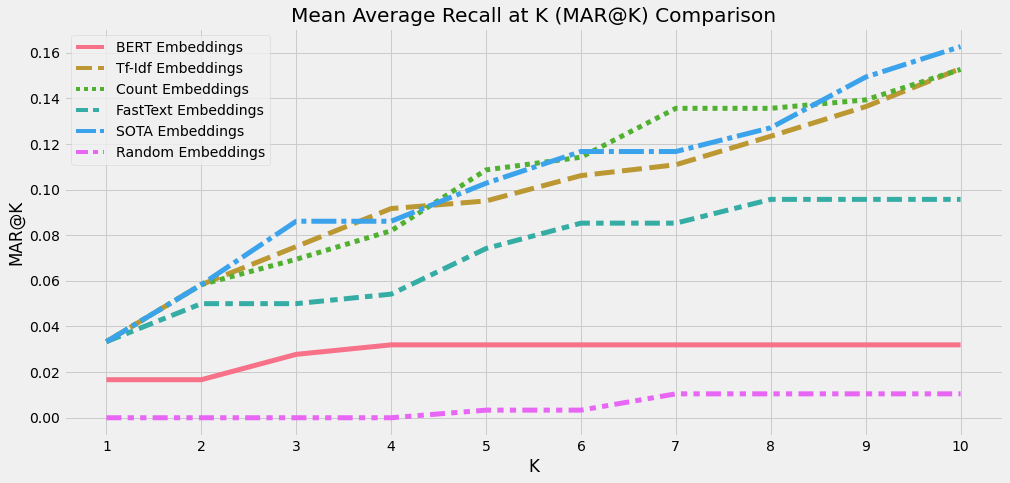

In [51]:
mark_scores = [bert_mark, tfidf_mark, count_mark, fasttext_mark, SOTA_mark, random_mark]
index = range(1,10+1)
names = ['BERT Embeddings', 'Tf-Idf Embeddings', 'Count Embeddings', 'FastText Embeddings', 'SOTA Embeddings', 'Random Embeddings']

fig = plt.figure(figsize=(15, 7))
mark_plot(mark_scores, model_names=names, k_range=index)

### Prediction Coverage:

In [52]:
catalog = encoder.transform(df['Name'])
bert_coverage = recmetrics.prediction_coverage(result.bert_preds.values, catalog)
tfidf_coverage = recmetrics.prediction_coverage(result.tfidf_preds.values, catalog)
count_coverage = recmetrics.prediction_coverage(result.count_preds.values, catalog)
fasttext_coverage = recmetrics.prediction_coverage(result.fasttext_preds.values, catalog)
SOTA_coverage = recmetrics.prediction_coverage(result.SOTA_preds.values, catalog)
random_coverage = recmetrics.prediction_coverage(result.random_preds.values, catalog)

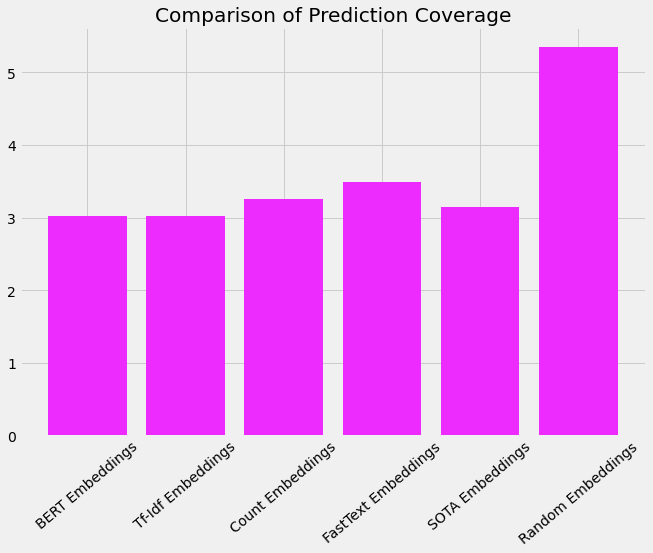

In [53]:
coverage_scores = [bert_coverage, tfidf_coverage, count_coverage, fasttext_coverage, SOTA_coverage, random_coverage]
names = ['BERT Embeddings', 'Tf-Idf Embeddings', 'Count Embeddings', 'FastText Embeddings', 'SOTA Embeddings', 'Random Embeddings']

fig = plt.figure(figsize=(10, 7))
plt.bar(names, coverage_scores)
plt.title('Comparison of Prediction Coverage')
plt.xticks(rotation=40)
plt.savefig('preds_cov.png', bbox_inches = 'tight')
plt.show()

### Catalog Coverage:

In [54]:
catalog = encoder.transform(df['Name'])
bert_coverage = recmetrics.catalog_coverage(result.bert_preds.values, catalog, 10)
tfidf_coverage = recmetrics.catalog_coverage(result.tfidf_preds.values, catalog, 10)
count_coverage = recmetrics.catalog_coverage(result.count_preds.values, catalog, 10)
fasttext_coverage = recmetrics.catalog_coverage(result.fasttext_preds.values, catalog, 10)
SOTA_coverage = recmetrics.catalog_coverage(result.SOTA_preds.values, catalog, 10)
random_coverage = recmetrics.catalog_coverage(result.random_preds.values, catalog, 10)

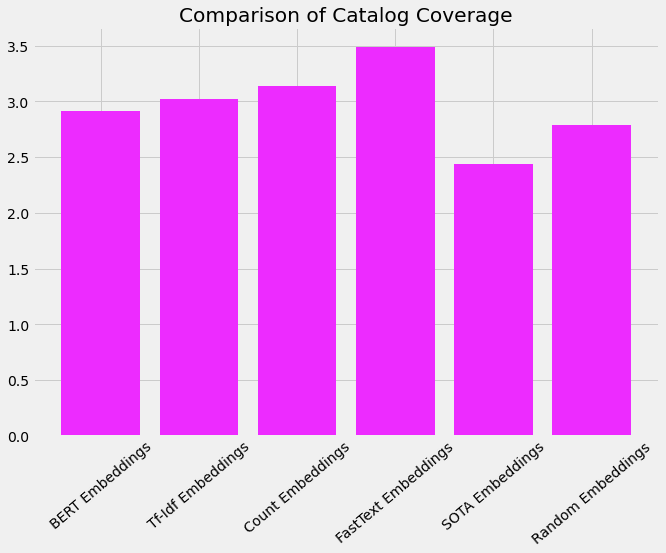

In [55]:
coverage_scores = [bert_coverage, tfidf_coverage, count_coverage, fasttext_coverage, SOTA_coverage, random_coverage]
names = ['BERT Embeddings', 'Tf-Idf Embeddings', 'Count Embeddings', 'FastText Embeddings', 'SOTA Embeddings', 'Random Embeddings']

fig = plt.figure(figsize=(10, 7))
plt.bar(names, coverage_scores)
plt.title('Comparison of Catalog Coverage')
plt.xticks(rotation=40)
plt.savefig('cat_cov.png', bbox_inches = 'tight')
plt.show()

### Novelty Of Recommendations:

In [56]:
nov = pd.Series(encoder.transform(df['Name'])).value_counts()
pop = dict(nov)

bert_novelty = recmetrics.novelty(result.bert_preds.values, pop, len(pop), 10)
tfidf_novelty = recmetrics.novelty(result.tfidf_preds.values, pop, len(pop), 10)
count_novelty = recmetrics.novelty(result.count_preds.values, pop, len(pop), 10)
fasttext_novelty = recmetrics.novelty(result.fasttext_preds.values, pop, len(pop), 10)
SOTA_novelty = recmetrics.novelty(result.SOTA_preds.values, pop, len(pop), 10)
random_novelty = recmetrics.novelty(result.random_preds.values, pop, len(pop), 10)

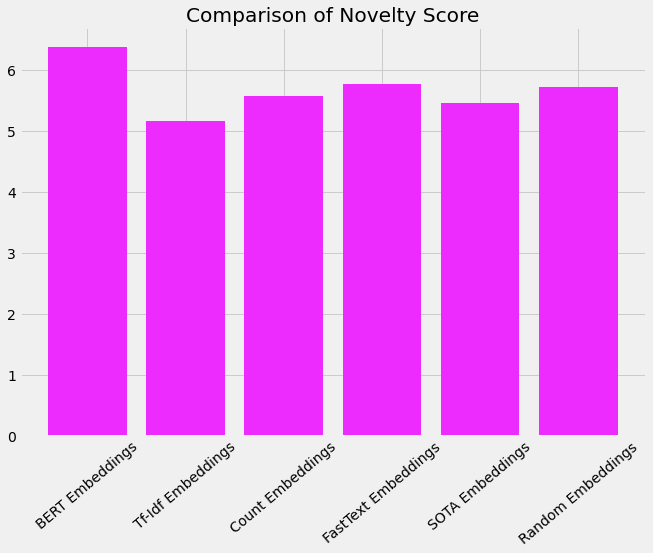

In [57]:
coverage_scores = [bert_novelty[0], tfidf_novelty[0], count_novelty[0], fasttext_novelty[0], SOTA_novelty[0], random_novelty[0]]
names = ['BERT Embeddings', 'Tf-Idf Embeddings', 'Count Embeddings', 'FastText Embeddings', 'SOTA Embeddings', 'Random Embeddings']

fig = plt.figure(figsize=(10, 7))
plt.bar(names, coverage_scores)
plt.title('Comparison of Novelty Score')
plt.xticks(rotation=40)
plt.savefig('novelty_score.png', bbox_inches = 'tight')
plt.show()

# Pipeline Stage 2:

In [58]:
class Recommender:
    def __init__(self, data):
        self.df = data
        
        cat_dummies = self.df['Veg/Non-Veg'].str.get_dummies()
        nutrient_dummies = self.df['Nutrient'].str.get_dummies()
        disease_dummies = self.df['Disease'].str.get_dummies(sep=' ')
        diet_dummies = self.df['Diet'].str.get_dummies(sep=' ')
        feature_df = pd.concat([cat_dummies, nutrient_dummies, disease_dummies, diet_dummies], axis=1)
        
        self.data = feature_df
        
    def get_recommendations(self, inputs, k):
        total_features = self.data.columns
        temp = dict()
        for i in total_features:
            if i in inputs:
                temp[i] = 1
            else:
                temp[i] = 0
        
        temp = pd.DataFrame([temp])
        
        model = NearestNeighbors(n_neighbors=k, algorithm='ball_tree')
        model.fit(self.data)
        
        distances, indices = model.kneighbors(temp)
        
        results = self.df.iloc[indices[0]].reset_index(drop=True)
        results['Disance'] = distances[0]
        return results

# Inference:

In [59]:
filtered_df = filter_SOTA(df, bert_embeddings, tfidf_embeddings, count_embeddings, fasttext_embeddings, 'sweet')

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [60]:
ob = Recommender(filtered_df)
sample_input = ['veg', 'high_protien_diet', 'gluten_free_diet', 'diabeties', 'anemia', 'calcium', 'protien']

results = ob.get_recommendations(sample_input, 5)
results

,Name,Category,Veg/Non-Veg,Nutrient,Disease,Diet,Ingredients,Description,text,bert_score,tfidf_score,count_score,fasttext_score,ensemble_score,Disance
0,grilled almond barfi (sugar free),barfi,veg,calcium,goitre hypertension,low_fat_diet ketogenic_diet gluten_free_diet v...,"Khoya, Sweetener (Optional), Almonds (Crushed)",NaN,grilled almond barfi sugar free barfi veg calc...,0.264460,0.000000,0.000000,0.621826,0.000000,2.828427
1,shrimp &amp; cilantro ceviche,coriander,veg,vitamin_a,anemia goitre,ketogenic_diet,"prawns, gherkin, onion, cilantro, mix bell pep...",NaN,shrimp amp cilantro ceviche coriander veg vita...,0.214013,0.107007,0.119523,0.651848,0.117020,2.828427
2,shrimp &amp; cilantro ceviche,coriander,veg,vitamin_a,anemia goitre,ketogenic_diet,"prawns, gherkin, onion, cilantro, mix bell pep...",NaN,shrimp amp cilantro ceviche coriander veg vita...,0.214013,0.107007,0.119523,0.651848,0.117020,2.828427
3,puffed rice squares,rice,veg,carbohydrates,obesity diabeties anemia,high_protien_diet vegan_diet dash_diet ketogen...,"puffed rice, nuts, honey, jaggery, butter, kew...",As a child I remember that we used puffed rice...,puffed rice square rice veg carbohydrate obesi...,0.145313,0.000000,0.000000,0.627688,0.000000,2.828427
4,carrot ginger soup,soup,veg,sodium,obesity,alkaline_diet high_fiber_diet,"Carrot, olive oil, salt, vegetable stock, ging...",Sweet carrots puree is seasoned with a tang of...,carrot ginger soup soup veg sodium obesity alk...,0.240094,0.113928,0.125000,0.677591,0.122786,3.162278
